In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [4]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [5]:
f_in = "../trajectory/k_1_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D"); # Diffusion coefficient, unit: angstrom^2 s-1

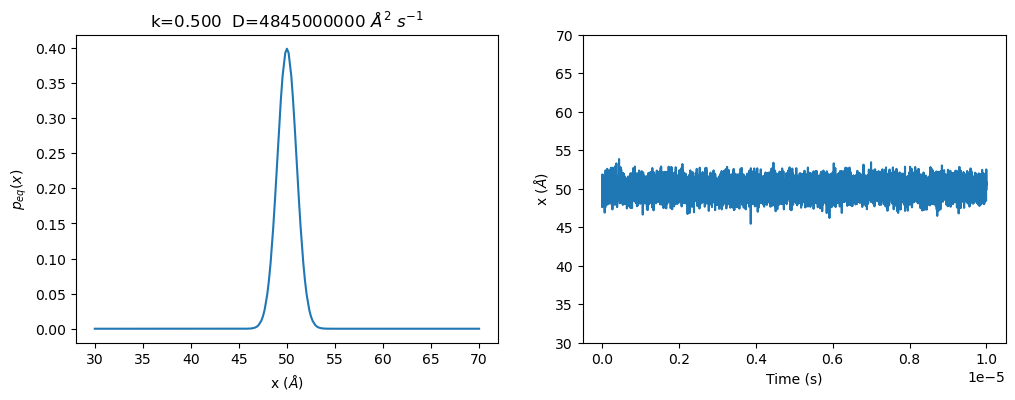

In [90]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.0f \$\\AA^2~ s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Complete EM

In [15]:
# Set Parameters
Nv = 72
max_n_iteration = 100
mu_guess = 45.

f_out_pcontain = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_smooth.jld" mu_guess xavg
f_out_d_record = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_D_smooth.jld" mu_guess xavg
f_out_l_record = @sprintf "/home/yizaochen/codes/julia/EM_data/p0_xavg_%d_pref_xavg_%d_v2_loglikelihood_smooth.jld" mu_guess xavg

k = 0.1 # unit: kcal/mol/angstrom^2
V = harmonic_well_k_mean(xref, k, mu_guess)
rho_guess = get_rhoeq(V, w0)
p_guess = rho_guess .* rho_guess;

In [16]:
ini_guess_D_info, p_container, D_records, log_likelihood_records = complete_em_v0(max_n_iteration, N, p_guess, Nh, Np, 
    xratio, xavg, Nv, tau, y_record, save_freq, xref, e_norm, w0, f_out_pcontain, f_out_d_record, f_out_l_record);

Initialize D......Start
Initialize D......End
Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Iteration-ID: 7
Iteration-ID: 8
Iteration-ID: 9
Iteration-ID: 10
Iteration-ID: 11
Iteration-ID: 12
Iteration-ID: 13
Iteration-ID: 14
Iteration-ID: 15
Iteration-ID: 16
Iteration-ID: 17
Iteration-ID: 18
Iteration-ID: 19
Iteration-ID: 20
Iteration-ID: 21
Iteration-ID: 22
Iteration-ID: 23
Iteration-ID: 24
Iteration-ID: 25
Iteration-ID: 26
Iteration-ID: 27
Iteration-ID: 28
Iteration-ID: 29
Iteration-ID: 30
Iteration-ID: 31
Iteration-ID: 32
Iteration-ID: 33
Iteration-ID: 34
Iteration-ID: 35
Iteration-ID: 36
Iteration-ID: 37
Iteration-ID: 38
Iteration-ID: 39
Iteration-ID: 40
Iteration-ID: 41
Iteration-ID: 42
Iteration-ID: 43
Iteration-ID: 44
Iteration-ID: 45
Iteration-ID: 46
Iteration-ID: 47
Iteration-ID: 48
Iteration-ID: 49
Iteration-ID: 50
Iteration-ID: 51
Iteration-ID: 52
Iteration-ID: 53
Iteration-ID: 54
Iteration-ID: 55
Iteration-ID: 56
Iteration-I

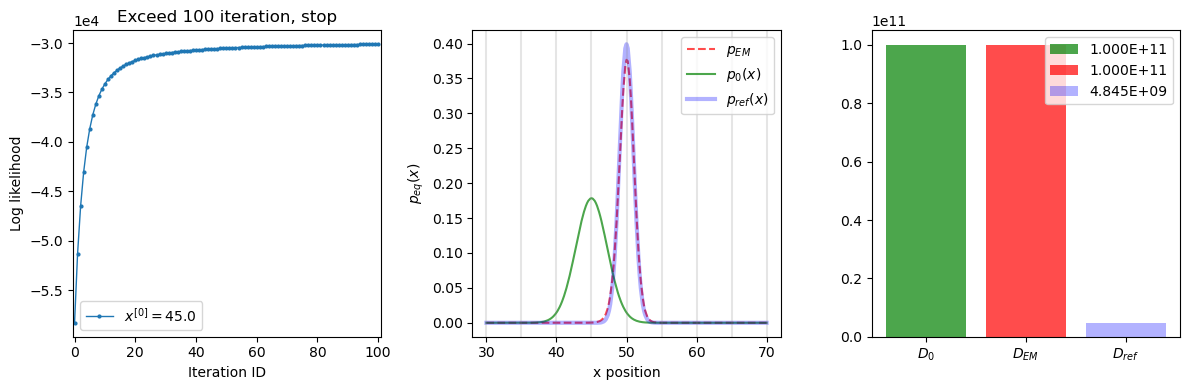

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

lastem_id = 100

ax = axes[1]
xarray = 0:lastem_id
label = @sprintf "\$x^{[0]}=%.1f\$" mu_guess
ax.plot(xarray, log_likelihood_records[1:lastem_id+1], "-o", linewidth=1, markersize=2, label=label)
ax.legend()
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
ax.set_xlim(-0.5, max_n_iteration+1)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
title = @sprintf "Converge at iteration %d" lastem_id
title = "Exceed 100 iteration, stop"
ax.set_title(title)

ax = axes[2]
ax.plot(xref, p_container[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{EM}\$")
ax.plot(xref, rho_guess .* rho_guess, label="\$ p_0(x) \$", alpha=0.7, color="green")
ax.plot(xref, rho_eq .* rho_eq, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
for xline in 30:5:70
    ax.axvline(xline, color="grey", alpha=0.2)
end
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[3]
xarray = [1, 2, 3]
label1 = @sprintf "%.3E" D_records[1]
label2 = @sprintf "%.3E" D_records[lastem_id+1]
label3 = @sprintf "%.3E" D
ax.bar(1, D_records[1], color="green", alpha=0.7, label=label1)
ax.bar(2, D_records[lastem_id+1], color="red", alpha=0.7, label=label2)
ax.bar(3, D, color="blue", alpha=0.3, label=label3)
ax.set_xticks(xarray)
ax.set_xticklabels(["\$D_0\$", "\$D_{EM}\$", "\$D_{ref}\$"])
ax.legend()

plt.tight_layout()
svgfile = @sprintf "./em_p0_avg_%d_pref_xavg_%d.svg" mu_guess xavg
#plt.savefig(svgfile)
plt.show()

In [24]:
log_likelihood_records[101] - log_likelihood_records[100]

3.7363451877499756